# Weave smart meter data

The UK energy regulator OFGEM requires distribution network operators (DNOs) in the UK to publish aggregated smart meter readings from their networks. We've taken that data and made it easier to use by republishing it as combined GeoParquet files.

This notebook gives an overview of how you can use that data, with examples of code using PyArrow and GeoPandas.

## Setup
This is a jupyter python notebook, you're looking at the saved output from us running it on our own machine. 

To run it on your machine you need a few dependencies installed - particularly a relatively recent version of Jupyter and Geopandas. There are many ways to achieve this in the modern python ecosystem, but we like [UV](https://docs.astral.sh/uv/getting-started/installation/) and include in this repository `pyproject.toml` and `uv.lock` files which should make it easy to replicate our development environment. 

Once you have UV installed, you can simply run the jupyter server:
```shell
uv run jupyter notebook
```

On the first run it will download the required dependencies, including the version of python we specify, install those into a virtual environment and then launch a jupyter server, which in turn should open a browser window. In that window, you should see a Jupyter interface, from which you can open the `/docs` folder and then find this file.

## How do I get the data?
The data is a series of geoparquet files, hosted on AWS' S3. You can read it straight into a GeoDataFrame with GeoPandas:

```python
import geopandas as gpd
gdf = gpd.read_parquet("s3://weave.energy/smart-meter")
```

**However**, unless you have a *lot* of RAM (128GB+), this is probably not a good idea. There is a lot of data and it eats your memory for breakfast. 

Instead, you're likely going to want to be selective about what you load.

### Using GeoPandas
Let's use an example of selecting a single settlement period and plotting it on a pretty map:

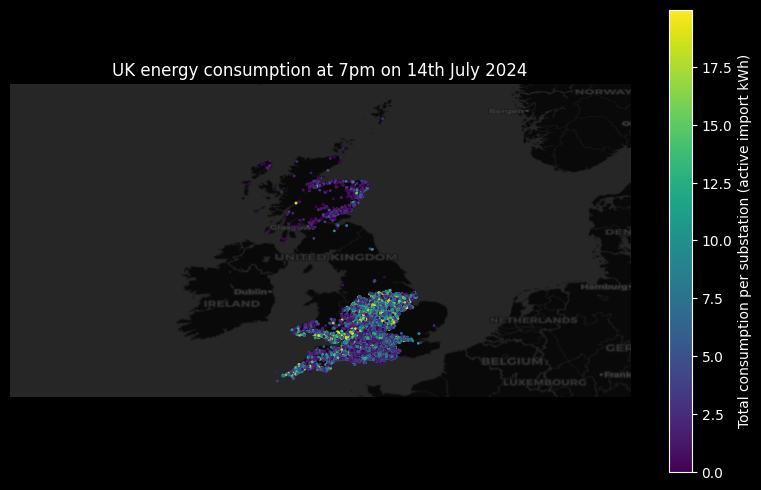

In [25]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Kickoff of the UEFA Euro 2024 final, in case you were wondering
settlement_period = pd.Timestamp("2024-07-14 20:00Z")

gdf = gpd.read_parquet("s3://weave.energy/smart-meter", filters=[("data_collection_log_timestamp", "=", settlement_period)])
# Sum up energy consumption per secondary substation
substations = gdf.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry", crs=4326)
# There are still issues with extreme outliers, so we filter them out
substations = substations[substations["total_consumption_active_import"] < 20000]

# Turn Wh consumption into kWh
substations["total_consumption_active_import"] /= 1000

ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=1, legend=True, legend_kwds={"label": "Total consumption per substation (active import kWh)"}, figsize=(10, 6))
ax.set_title("UK energy consumption at 7pm on 14th July 2024")
ax.set_axis_off()
ax.set_xlim(-18, 10)
ax.set_ylim(49.25, 61.5)
ax.set_facecolor("#1B2526")
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)


This is pretty quick, because parquet files allow us to "push down" the filtering to the storage layer. Under the hood, GeoPandas (really pyarrow, that GeoPandas is using) lists the files in our S3 bucket under `smart-meter/` and interrogates the metadata for all of them in order to find our what byte ranges it needs to download to get the rows you asked for. Since we sort our data by timestamp, it can request a lot less than the full dataset. This also results in a very manageable dataset in memory, because we're loading just the data we want. We could actually improve the performance here by writing a folder-level `_metadata` file so you don't even need to read the metadata for every monthly file, but we haven't done that yet.

Note you can use a whole range of filtering expressions here: `=` or `==`, `!=`, `<`, `>`, `<=`, `>=`, `in` and `not in`, as well as combining multiple expressions using boolean logic (see [PyArrow's docs](https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table) for more details).

Some more examples you might want to try:

### By bounding box

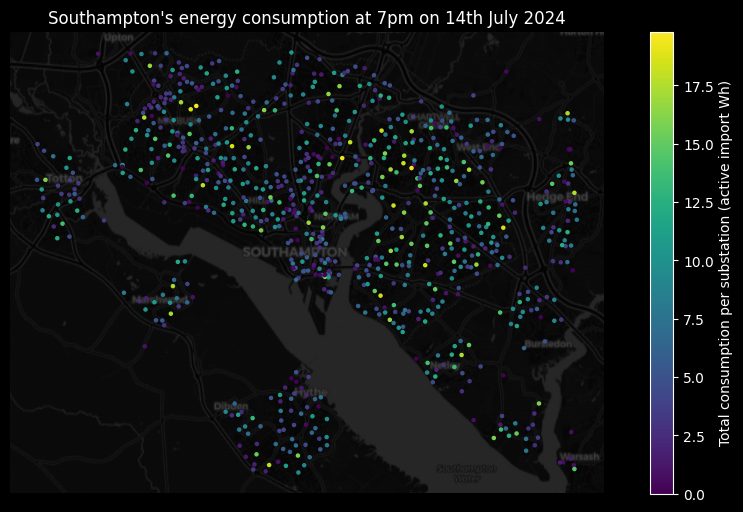

In [23]:
# The area around Southampton, in min_x, min_y, max_x, max_y format
# (Pro tip: ChatGPT is excellent for creating these)
bbox = (-1.5,50.85,-1.3,50.95)
gdf = gpd.read_parquet("s3://weave.energy/smart-meter", bbox=bbox, filters=[("data_collection_log_timestamp", "=", pd.Timestamp("2024-07-14 20:00Z"))])
substations = gdf.groupby(["secondary_substation_unique_id", "geometry"], as_index=False).sum("total_consumption_active_import").set_geometry("geometry", crs=4326)
substations = substations[substations["total_consumption_active_import"] < 20000]
# Turn Wh consumption into kWh
substations["total_consumption_active_import"] /= 1000
ax = substations.plot(kind="geo", column="total_consumption_active_import", markersize=5, legend=True, legend_kwds={"label": "Total consumption per substation (active import Wh)"}, figsize=(12, 6))
ax.set_title("Southampton's energy consumption at 7pm on 14th July 2024")
ax.set_axis_off()
ax.set_facecolor("#1B2526")
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.DarkMatter, attribution=False)

The cool thing with geoparquet, over just regular parquet is that this ability to "push down" the filtering applies to geospatial filters like this bounding box too.

In full, we've sorted the data by:
- Timestamp (`data_collection_log_timestamp`)
- DNO (`dno_alias`)
- Substation (`secondary_substation_unique_id`)
- Feeder (`lv_feeder_unique_id`)

So the use of any of those columns in a filter should be pretty efficient.

### By secondary substation id

By pulling out a single substation, we can take a closer look at the actual shape of the data. Note - although this ends up with a pretty small dataset in memory, it does require downloading a significant amount of data. Although the data is sorted, a single substation is still spread out over quite a lot of each file, so you have to download most of it. We could improve this with an alternative partitioning scheme, so if extracting specific substations or feeders is really important to you, let us know!

In [65]:
gdf = gpd.read_parquet("s3://weave.energy/smart-meter", filters=[("dno_alias", "==", "SSEN"), ("secondary_substation_unique_id", "==", "6400603160")])
gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39933 entries, 0 to 39932
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       39933 non-null  object             
 1   dno_alias                        39933 non-null  object             
 2   aggregated_device_count_active   39597 non-null  float64            
 3   total_consumption_active_import  39597 non-null  float64            
 4   data_collection_log_timestamp    39933 non-null  datetime64[ms, UTC]
 5   geometry                         39933 non-null  geometry           
 6   secondary_substation_unique_id   39933 non-null  object             
 7   lv_feeder_unique_id              39933 non-null  object             
dtypes: datetime64[ms, UTC](1), float64(2), geometry(1), object(4)
memory usage: 2.4+ MB


See [our FAQ](https://docs.google.com/document/d/16tOUcaxGzSzuTw2JyR2O5yp_q7VM2J4jTV3lAkV1skQ/edit?tab=t.0#heading=h.23nyfir20pt1) for what all these fields mean and some caveats around using them, but the key thing to understand is that we have Wh energy consumption, per half-hour, for every low-voltage feeder.

We can see a bit more of an overview of how that data looks here with some aggregation:

In [66]:
gdf.groupby("lv_feeder_unique_id").agg({
    "lv_feeder_unique_id": ["count"],
    "data_collection_log_timestamp": ["min", "max"],
    "aggregated_device_count_active": ["min", "max"],
    "total_consumption_active_import": ["min", "max"]
})

lv_feeder_unique_id data_collection_log_timestamp  \
                                  count                           min   
lv_feeder_unique_id                                                     
640060316002                      13631     2024-02-12 00:30:00+00:00   
640060316003                      13631     2024-02-12 00:30:00+00:00   
640060316004                      12671     2024-02-12 00:30:00+00:00   

                                              aggregated_device_count_active  \
                                          max                            min   
lv_feeder_unique_id                                                            
640060316002        2024-11-25 00:00:00+00:00                            9.0   
640060316003        2024-11-25 00:00:00+00:00                           27.0   
640060316004        2024-11-25 00:00:00+00:00                            5.0   

                           total_consumption_active_import           
                       max                             min      max  
lv_feeder_unique_id                                                  
640060316002          74.0                           710.0  21238.0  
640060316003         250.0                          2395.0  53889.0  
640060316004          26.0                           290.0   9100.0

So the substation we've chosen has three low-voltage feeders, and we've got data starting in Feb and running until a few days ago. The feeders themselves vary a lot in terms of how many houses they serve and therefore the total consumption you might see.

Note also how the number of houses (devices) can vary over time! There are power cuts and other problems which prevent meters from providing their data, so we have to be careful when we use the data.

Lets look at this consumption visually:

<Axes: title={'center': 'Daily kWh consumption per low-voltage feeder for a substation in Southampton'}, xlabel='Date', ylabel='Consumption (kWh)'>

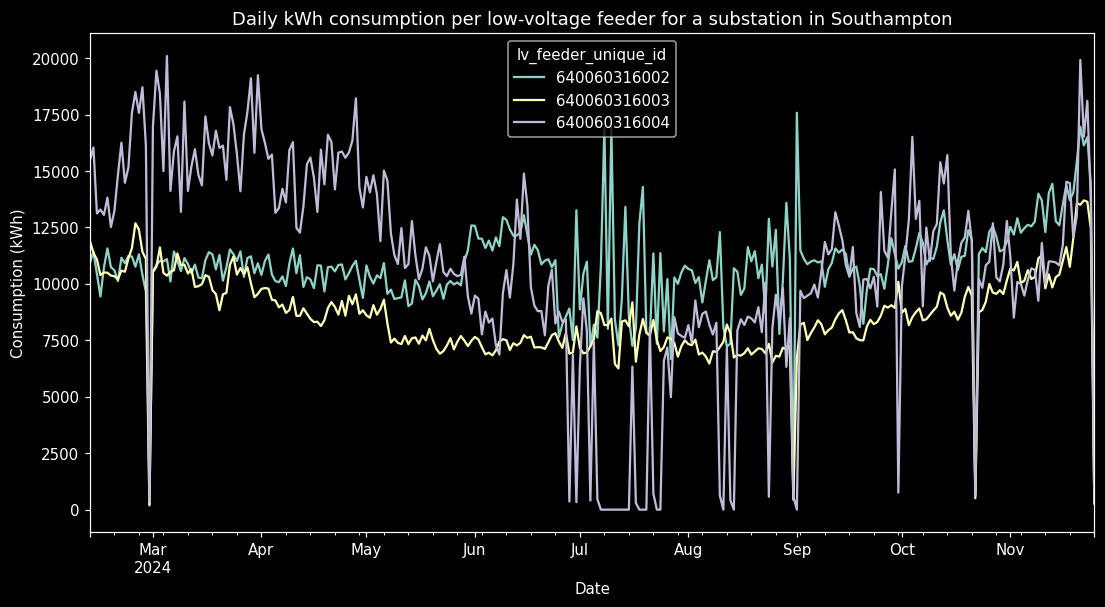

In [71]:
# There are some issues around the clock change in October with duplicated settlement periods
deduped_gdf = gdf.drop_duplicates(subset=["data_collection_log_timestamp", "lv_feeder_unique_id"]).copy()
deduped_gdf["normalised_consumption"] = deduped_gdf["total_consumption_active_import"] / deduped_gdf["aggregated_device_count_active"]
timeseries = deduped_gdf.pivot(index="data_collection_log_timestamp", columns="lv_feeder_unique_id", values="normalised_consumption")
timeseries.resample("d").sum().plot(figsize=(12,6), xlabel="Date", ylabel="Consumption (Wh)", title="Daily Wh consumption per low-voltage feeder for a substation in Southampton")

This code highlights some of the other issues you're likely to encounter when working with the data:

- Outliers. There are some extreme values in the data which are not realistic. We're working with the DNOs to understand where these come from and what we can do about them.
- At the daylight savings switchover, some rows are duplicated, giving you two values for 1am on the 27th October, and a doubled value for 1:30am
- Some pretty big gaps in the data, e.g. in mid July. That could be expected to be a time of lower energy use, but not zero for days on end! Unfortunately, our conversations with DNOs have revealed that this was due to a bug on their end, which cannot now be rectified, so that data is lost.

## Using PyArrow
In developing our data pipeline, we've become more familiar with PyArrow - the Python API of Apache Arrow - which underpins GeoPandas parquet support. In their own words:

> Apache Arrow is a development platform for in-memory analytics. It contains a set of technologies that enable big data systems to store, process and move data fast.

We have found it extremely useful when dealing with smart meter data, partly because it is faster, but also because it's Parquet toolkit is more extensive.

If you've gotten past the stage of playing with the data in a dataframe and want to productionise something, it could be a good option:

In [75]:
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
import geopandas as gpd

# You can apply filters to a dataset just like in geopandas read_parquet, except the
# datatypes are pyarrow's. Here's an example of filtering by a timestamp
settlement_period = pa.scalar(datetime(2024, 7, 14, 20, 0, 0), type=pa.timestamp("ms", tz="UTC"))
ds = pq.ParquetDataset("s3://weave.energy/smart-meter", filters=[["data_collection_log_timestamp", "=", settlement_period]])
# ds has useful overview properties like schema, files, etc
# When you want to read some data (and optionally turn it into a Pandas dataframe), it's
# easy. e.g.
gdf = gpd.GeoDataFrame.from_arrow(ds.read())
# Now you can work with gdf as you would with any other GeoDataFrame
# Plus, all the filters we listed above work just the same.
gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66807 entries, 0 to 66806
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       66807 non-null  object             
 1   dno_alias                        66807 non-null  object             
 2   aggregated_device_count_active   60657 non-null  float64            
 3   total_consumption_active_import  60657 non-null  float64            
 4   data_collection_log_timestamp    66807 non-null  datetime64[ms, UTC]
 5   geometry                         66807 non-null  geometry           
 6   secondary_substation_unique_id   66807 non-null  object             
 7   lv_feeder_unique_id              66807 non-null  object             
dtypes: datetime64[ms, UTC](1), float64(2), geometry(1), object(4)
memory usage: 4.1+ MB
